# Import & Install libraries

Voxelfuse library is used to create and save meshes from np array.
https://cdbrauer.github.io/VoxelFuse/

Tensorflow-gan is adds util functions for training and evaluating gan models.
https://github.com/tensorflow/gan 

In [ ]:
!pip install voxelfuse
!pip install tensorflow-gan 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 63.0 MB 1.4 MB/s 
     |████████████████████████████████| 995 kB 45.5 MB/s 
     |████████████████████████████████| 3.3 MB 41.4 MB/s 
     |████████████████████████████████| 8.3 MB 1.1 MB/s 
     |████████████████████████████████| 15.1 MB 32.1 MB/s 
     |████████████████████████████████| 265 kB 55.0 MB/s 
     |████████████████████████████████| 167 kB 50.7 MB/s 
     |████████████████████████████████| 129 kB 56.9 MB/s 
     |████████████████████████████████| 38.1 MB 1.6 MB/s 
     |████████████████████████████████| 232 kB 62.8 MB/s 
     |████████████████████████████████| 34.5 MB 1.3 MB/s 
     |████████████████████████████████| 338 kB 42.6 MB/s 
     |████████████████████████████████| 59.9 MB 57.2 MB/s 
     |████████████████████████████████| 51 kB 4.8 MB/s 
  Created wheel for py-vox-io: filename=py_vox_io-0.1-py3-none-any.whl size=5719 sha256=d8

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 367 kB 5.0 MB/s 


In [ ]:
import os
import scipy
import scipy.io
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Input, Conv3D, Conv3DTranspose, Activation, BatchNormalization, LeakyReLU, Flatten, Reshape, Dense, Dropout, UpSampling3D
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras import backend 
from tensorflow.keras.constraints import Constraint
import tensorflow_gan as tfgan
from tensorflow import keras
from google.colab import output
from tqdm import tqdm
import matplotlib.pyplot as plt
from google.colab import output
from scipy import ndimage, misc ## to scale up the model without exporting
from sklearn.preprocessing import MinMaxScaler

from voxelfuse.voxel_model import VoxelModel
from voxelfuse.mesh import Mesh
from voxelfuse.primitives import generateMaterials
import matplotlib.pyplot as plt
from datetime import date
output.clear()

ModuleNotFoundError: ignored

In [ ]:


import matplotlib.pyplot as plt
from datetime import date
output.clear()

Connect colab to your local drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive',  force_remount = True)
output.clear()

#Load and prepare the data

###Setup folders 

Useful function to create new folders

In [ ]:
def NewDir(path, name):
  if os.path.isdir ( path + str(name) ) == False:
    os.mkdir( path + str(name) )
  return str(path+'/'+ name +'/')


preparing the folder structure and storing filepaths in variables that we will use later in training.

set root_dir to the main folder that holds your notebooks for this class

set data_dir to the location of your dataset files


training_dir will create a new directory for each training day to ensure you don't override previously saved models  

/content/drive/MyDrive/AIA-IAAC/AIA-GANS-Interior/Dir1train/

/content/drive/MyDrive/AIA-IAAC/2-AIA-GANS-Interior/Dir1train

In [ ]:
# same as numpy colab 
root_dir= '/content/drive/MyDrive/AIA-IAAC/AIA-GANS-Interior/Dir1train'
work_dir = NewDir(root_dir,'/')
data_dir = NewDir(root_dir,'Datasets') + 'Dir1'
today = date.today()
train_date = str(today)+'_train'
training_dir = NewDir(work_dir, train_date)


checkpoints_path = NewDir(training_dir, 'tmp')

sample_path = NewDir(training_dir, 'sampling')


###Load dataset from txt file

Creates a function to read txt files, reshape and add them to a 4dimensional np_array of shape (number of samples, grid width, grid length, grid height)

In [ ]:
def LoadDatasetTxt(dir, *shape, name):
  files = os.listdir(dir)
  dataset=[]
  points = []
  data_num = 0
  for file in files[:]:
    data_num +=1
    if str(name) in file:
      data = np.loadtxt(dir + '/'+file)
      print (str(data_num) + ' files loaded' + " - " + file + " done")
      data = data.reshape(shape[0], shape[1], shape[2])

      dataset.append(data)
  return dataset


In [ ]:
data_dir

'/content/drive/MyDrive/AIA-IAAC/AIA-GANS-Interior/Dir1train/Datasets/Dir1'

In [ ]:
npy_x_name = 'Dataset1_3d_It3_64x64x64.npy'

Unskipp the next cell when loading new data from .txt files for the first time

In [ ]:
#--->Uncoment next line to skip this cell if loading npy file
%%script echo skipping

shape = [64, 64, 64]

x_data = LoadDatasetTxt(data_dir, *shape, name='iteration')

output.clear()

x_data = np.array (x_data)
x_data = np.swapaxes(x_data ,1,3)
print (x_data.shape)

np.save((data_dir + '/' + npy_x_name), x_data)


###Load dataset from .npy file

In [ ]:
data_dir

'/content/drive/MyDrive/AIA-IAAC/AIA-GANS-Interior/Dir1train/Datasets/Dir1'

'/content/drive/MyDrive/AIA-IAAC/AIA-GANS-Interior/AIA-GANS-Interior/Dir1/Dataset2_3d_64x64x64.npy'

/content/drive/MyDrive/AIA-IAAC/AIA-GANS-Interior/Dir1/Dataset2_3d_64x64x64.npy

/content/drive/MyDrive/AIA-IAAC/AIA-GANS-Interior/Dir1train/Datasets/Dir1/Dataset1_3d_It3_64x64x64.npy


'/content/drive/MyDrive/AIA-IAAC/AIA-GANS-Interior/Dir1train/Datasets/Dir1/Dataset2_3d_It3_64x64x64.npy'

In [ ]:
#Load dataset from .npy file

#--->uncomment next line if loading your data for the first time
#%%script echo skipping

dataset_x = np.load((data_dir + '/' + npy_x_name),allow_pickle=True)


x_data = dataset_x


print(dataset_x.shape)


(104, 64, 64, 64)


In [ ]:
randomize = np.arange(x_data.shape[0])

np.random.shuffle(randomize)

x_data = x_data[randomize]

#Visualise the data

###Visualisation Utils

In [ ]:
def ShowVoxelModel(voxels, figsize=(20, 20), axisoff=False, edgecolor = 'teal', facecolor='deepskyblue', alpha = 0.5, linewidth = 0.2):
    voxels = voxels

    fig = plt.figure(figsize=figsize)

    ax = plt.subplot(projection='3d')
    ax.set_proj_type('ortho')
    ax.voxels(voxels, 
    facecolor=facecolor,
    edgecolor=edgecolor,
    alpha = alpha,
    linewidth =linewidth)

    ax.invert_zaxis() #to invert the axes
   
    if axisoff:
        ax.set_axis_off()


    plt.show()

###Print

Long computation time! Only run if check is essential

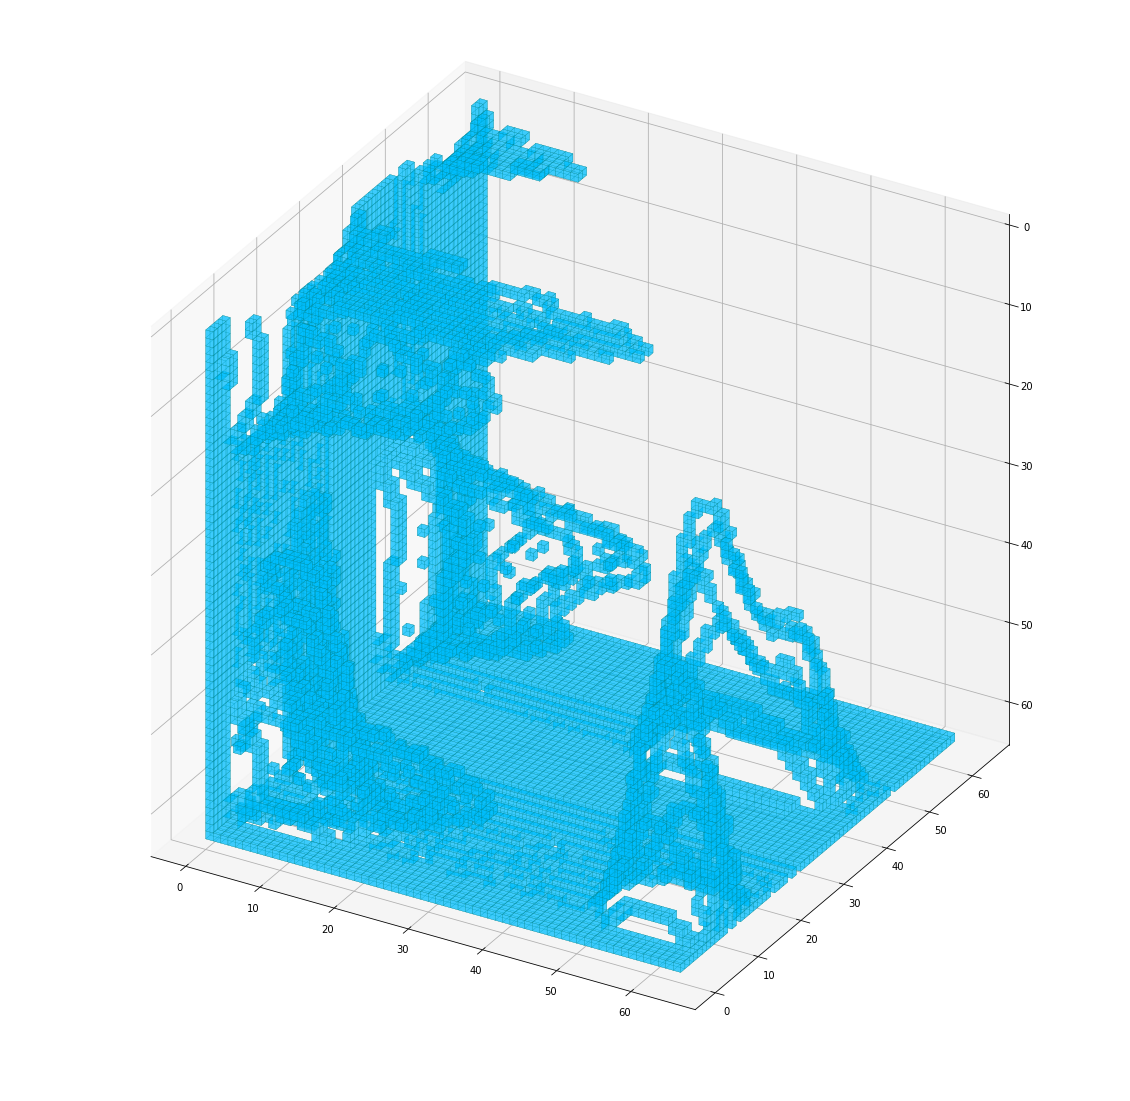

In [ ]:
#%%script echo skipping
ShowVoxelModel(x_data[50,:,:,:])

# Generator & Discriminator

###Define Generator and Discriminator models

In [ ]:
latent_dim = 100

In [ ]:
def build_generator(kernel_size=3, strides=2, latent_dim= latent_dim):
     model = Sequential()
     model.add(Input(shape=(latent_dim,)))

     model.add(Dense(units=2048, input_shape=(latent_dim,), use_bias=False))
     model.add(BatchNormalization(momentum=0.9))
     model.add(Reshape((2, 2, 2, 256)))
     model.add(Activation('relu'))
     model.add(Dropout(0.4))

     model.add(UpSampling3D())
     model.add(Conv3DTranspose(filters=512, kernel_size=kernel_size, padding='same', use_bias=False))
     model.add(BatchNormalization(momentum=0.9))
     model.add(Activation('relu'))

     model.add(UpSampling3D())
     model.add(Conv3DTranspose(filters=256, kernel_size=kernel_size, padding='same', use_bias=False))
     model.add(BatchNormalization(momentum=0.9))
     model.add(Activation('relu'))

     model.add(UpSampling3D())
     model.add(Conv3DTranspose(filters=128, kernel_size=kernel_size, padding='same', use_bias=False))
     model.add(BatchNormalization(momentum=0.9))
     model.add(Activation('relu'))

     model.add(UpSampling3D())
     model.add(Conv3DTranspose(filters=64, kernel_size=kernel_size, padding='same', use_bias=False))
     model.add(BatchNormalization(momentum=0.9))
     model.add(Activation('relu'))

     model.add(UpSampling3D())
     model.add(Conv3DTranspose(filters=1, kernel_size=kernel_size, padding='same', use_bias=False))
     model.add(Activation('sigmoid'))

     return model

In [ ]:
def build_discriminator(kernel_size=3, strides=2, im_dim=64):
    model = Sequential()
    model.add(Input(shape=(im_dim, im_dim, im_dim, 1)))
    
    model.add(Conv3D(filters=64, kernel_size=kernel_size, strides=strides, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.35))

    model.add(Conv3D(filters=128,kernel_size=kernel_size, strides=strides, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.35))

    model.add(Conv3D(filters=256,kernel_size=kernel_size, strides=strides, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.35))

    model.add(Conv3D(filters=512,kernel_size=kernel_size, strides=strides, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.35))

    model.add(Flatten())
    model.add(Dense(1))

    return model

###Utils functions

GAN utils

In [ ]:

def gradient_penalty(real, fake, epsilon): 
    global discriminator
    mixed_images = fake + epsilon * (real - fake)
    with tf.GradientTape() as tape:
        tape.watch(mixed_images) 
        mixed_scores = discriminator(mixed_images)
        

    gradient = tape.gradient(mixed_scores, mixed_images)[0]
    
    gradient_norm = tf.norm(gradient)
    penalty = tf.math.reduce_mean((gradient_norm - 1)**2)
    return penalty

# https://arxiv.org/pdf/1701.07875.pdf
# Generator want to minimize the distance (so it looks like the real)
# While the discriminator wants to maximize it (don't look real)
def generator_loss(fake_output):
    gen_loss = -1. * tf.math.reduce_mean(fake_output)
    return gen_loss

def discriminator_loss(real_output, fake_output, gradient_penalty):
    c_lambda = 10
    loss = tf.math.reduce_mean(fake_output) - tf.math.reduce_mean(real_output) + c_lambda * gradient_penalty
    return loss

Voxel model Utils

In [ ]:
def save_voxel(voxel_model, path):
    model = VoxelModel(voxel_model)  
    print('model = VoxelModel(voxel_model)  ')
    mesh = Mesh.fromVoxelModel(model)
    print('mesh = Mesh.fromVoxelModel(model)')
    mesh.export(path)


###Build the models

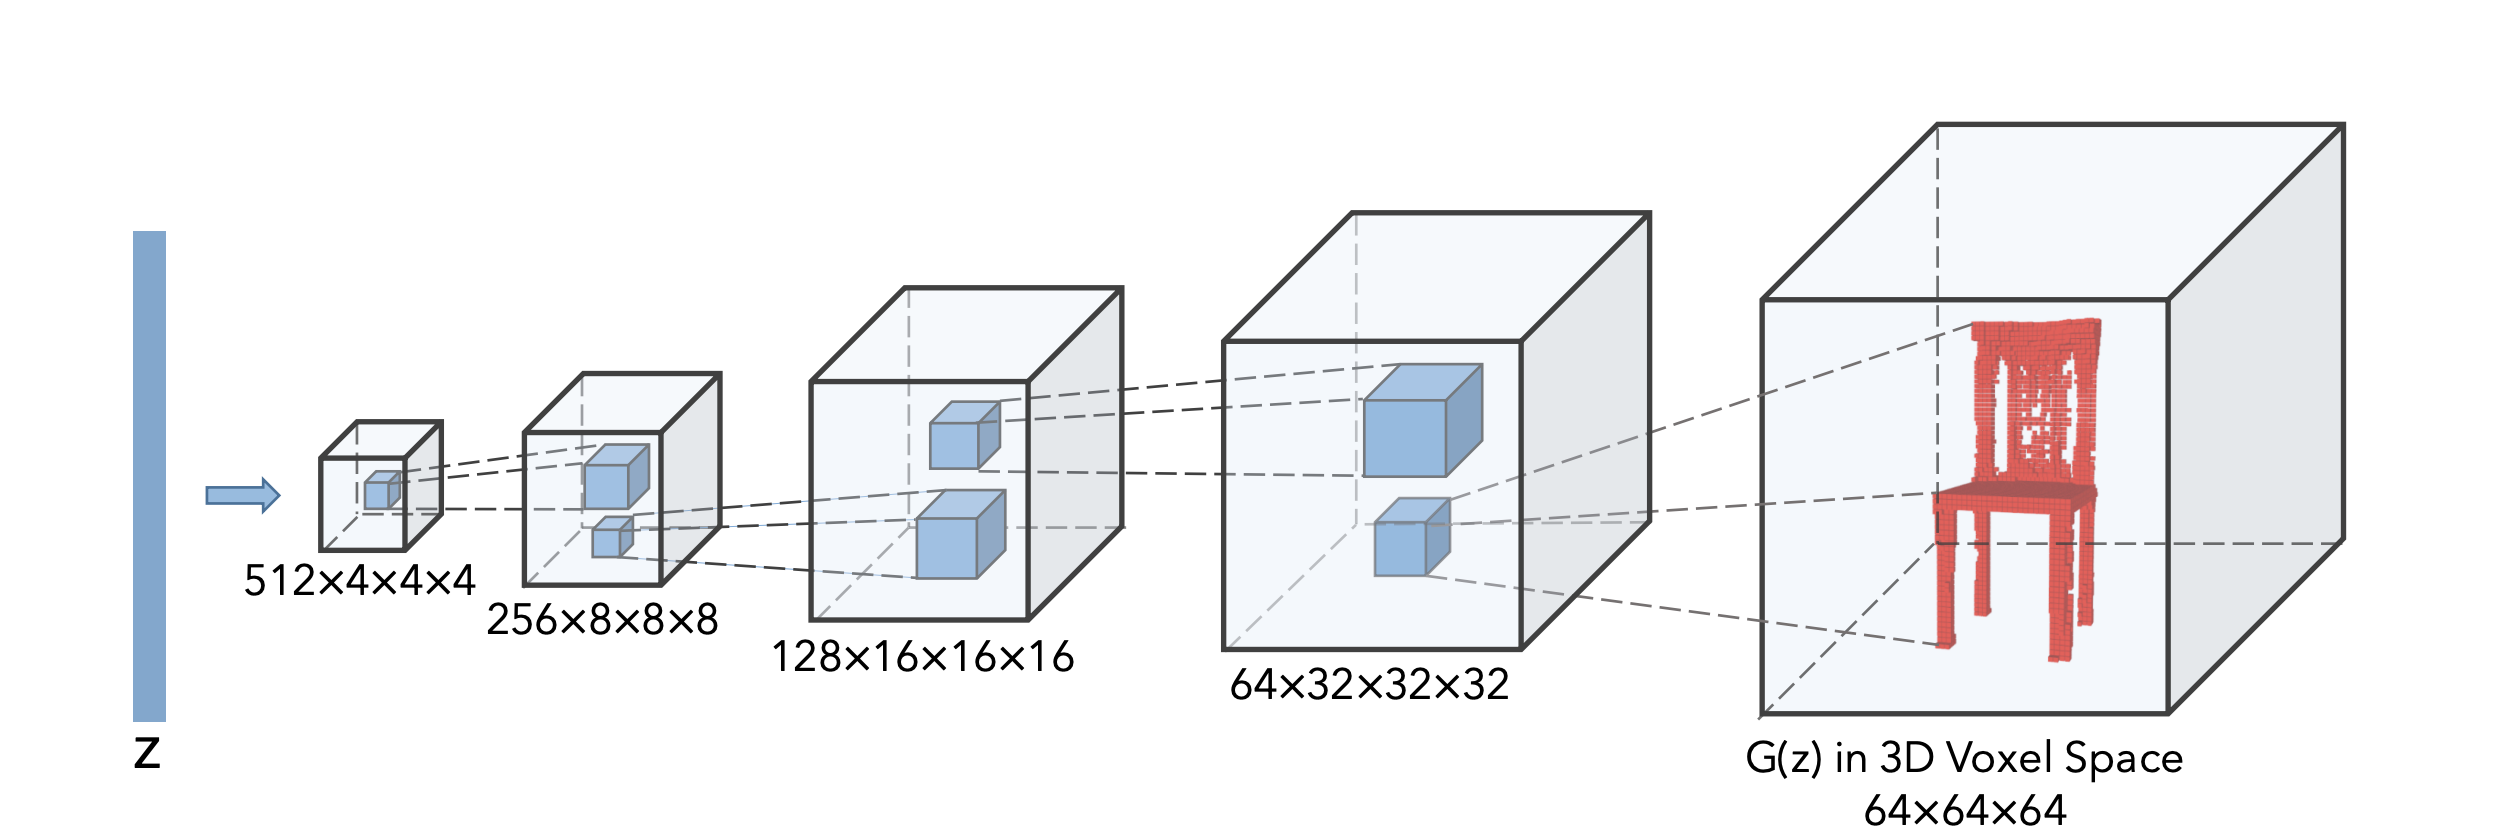

In [ ]:
discriminator = build_discriminator()
generator = build_generator()

In [ ]:
generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 2048)              204800    
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 reshape (Reshape)           (None, 2, 2, 2, 256)      0         
                                                                 
 activation (Activation)     (None, 2, 2, 2, 256)      0         
                                                                 
 dropout_4 (Dropout)         (None, 2, 2, 2, 256)      0         
                                                                 
 up_sampling3d (UpSampling3D  (None, 4, 4, 4, 256)     0         
 )                                                    

In [ ]:
discriminator.summary() # it will mirror of generator

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 32, 32, 32, 64)    1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 32, 64)    0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 32, 64)    0         
                                                                 
 conv3d_1 (Conv3D)           (None, 16, 16, 16, 128)   221312    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 16, 128)   0         
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 16, 128)   0         
                                                                 
 conv3d_2 (Conv3D)           (None, 8, 8, 8, 256)      8

# Training

We will load all meshes matrices saved in {dir_npz_64_path}

In [ ]:
training_data = x_data


###Creates the training loop

The training function includes functions to save samples and save model checkpoints at regular intervals during training.

//Experiment with optimizers and learning rates only once you got good understanding of the model 

The train definition includes a step to output a sample model in obj and txt format.

VoxelFuse library is used to create a voxelized version of the predicted numpy array. See documentation here: https://cdbrauer.github.io/VoxelFuse/voxelfuse/

In [ ]:
def train(sample_path, checkpoints_path, num_epochs=1000, batch_size=8, latent_dim=latent_dim, restore_D_path=None, restore_G_path=None, restore_epoch=0, sample_epoch = 50, save_epoch = 200,crit_repeats = 5 ):
    global discriminator
    global generator
    G_losses = []
    D_losses = []
    cur_step = 1

    dis_optim = RMSprop(learning_rate=0.0002, decay=6e-8) #Adam or RMSprop
    gen_optim = RMSprop(learning_rate=0.0001, decay=3e-8) #Adam or RMSprop

    # dis_optim = Adam(learning_rate=0.0002, beta_1=0.5)
    # gen_optim = Adam(learning_rate=0.0001, beta_1=0.5)

    if restore_D_path!=None:
      discriminator=tf.keras.models.load_model(restore_D_path)
      print(f'discriminator on path {restore_D_path} loaded successfully')

    if restore_G_path!=None:
      generator=tf.keras.models.load_model(restore_G_path)
      print(f'generator on path {restore_G_path} loaded successfully')

    generator.compile(optimizer=gen_optim)
    discriminator.compile(optimizer=dis_optim)

    dl, gl = [],[]
    for epoch in range(restore_epoch, num_epochs):
        #sample a random batch
        idx = np.random.randint(len(training_data), size=batch_size)
        real = training_data[idx]
        real = real.reshape(real.shape+(1,))

        noise = tf.random.normal([batch_size, latent_dim])

        # updating the critic multiple times every time you update the generator will help preventing the generator from overpowering the critic.
        mean_iteration_critic_loss = 0
        for i in range(crit_repeats):

          with tf.GradientTape() as disc_tape:
        
            generated_images = generator(noise, training=True)

            real_output = discriminator(real, training=True)
            fake_output = discriminator(generated_images, training=True)
        
            epsilon = tf.random.normal([batch_size, 1, 1, 1, 1], 0.0, 1.0)
        
            gp = gradient_penalty(real, generated_images, epsilon)
        
            disc_loss = discriminator_loss(real_output, fake_output, gp)
            mean_iteration_critic_loss += disc_loss.numpy() / crit_repeats

          D_losses += [mean_iteration_critic_loss]
          gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
          dis_optim.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

        with tf.GradientTape() as gen_tape:
          generated_images = generator(noise, training=True)
          fake_output = discriminator(generated_images, training=True)
          gen_loss = generator_loss(fake_output)
          
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gen_optim.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))


        G_losses += [gen_loss.numpy()]
        
        print('Training epoch {}/{}, d_loss: {},  g_loss: {}'.format(epoch+1, num_epochs, disc_loss, gen_loss))

        # sampling
        if epoch % sample_epoch == 0:
            gen_mean = sum(G_losses[-sample_epoch:]) / sample_epoch
            crit_mean = sum(D_losses[-sample_epoch:]) / sample_epoch
            print(f"Epoch {epoch}, step {cur_step}: Generator loss: {gen_mean}, Discriminator loss: {crit_mean}")
            step_bins = 10
            num_examples = (len(G_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                np.array(G_losses[:num_examples]).reshape(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                np.array(D_losses[:num_examples]).reshape(-1, step_bins).mean(1),
                label="Discriminator Loss"
            )
            plt.legend()
            plt.show()

            print("--------")
            print(f'len(G_losses) {len(G_losses)} step_bins {step_bins} num_examples {(len(G_losses) // step_bins) * step_bins}')
            print(f'D_losses {D_losses} num_examples {num_examples} step_bins {step_bins}')
            print(np.array(D_losses[:num_examples]).reshape(-1, step_bins).mean(1))
            print(np.array(G_losses[:num_examples]).reshape(-1, step_bins).mean(1))
            print("--------")
            if not os.path.exists(sample_path):
                os.makedirs(sample_path)
            print('Sampling...')
            sample_noise = np.random.uniform(-1.0, 1.0, size=[1, latent_dim]).astype(np.float64)
            voxel_model = generator.predict(sample_noise, verbose=1)
            voxel_model = voxel_model.reshape(voxel_model[0].shape[:-1])
            voxel_model = np.rint(voxel_model)
            print (voxel_model.shape)
            
            try:
              flat_model = np.reshape(voxel_model,(1, np.prod(voxel_model.shape)))
              np.savetxt(sample_path + f'/epoch_{epoch+1}.txt', flat_model, fmt='%s', delimiter=',')
            except Exception as ex:
              print('Could not save text file... Continuing training')
              print(ex)

            #Switch axes again before saving preview file
            new_voxel_model = np.swapaxes(voxel_model ,2,1)

            try:
              save_voxel(new_voxel_model, sample_path + f'/epoch_{epoch+1}.obj')
            except Exception as ex:
              print('Could not create voxel model... Continuing training')
              print(ex)

        # save weights
        if epoch % save_epoch == 0:
            if not os.path.exists(checkpoints_path):
                os.makedirs(checkpoints_path)
            generator.save(checkpoints_path + '/generator_epoch_' + str(epoch+1))
            discriminator.save(checkpoints_path + '/discriminator_epoch_' + str(epoch+1))
        cur_step += 1


###Train the model!

///Use the trick below to increase your wake time

https://maneeshkadanasseril.medium.com/how-to-stop-colab-from-disconnecting-2021-solution-ae5721e3838



```
function ClickConnect(){
console.log("Working"); 
document.querySelector("colab-toolbar-button#toolbar-add-code").click() 
}setInterval(ClickConnect,(20*60*1000))
```



In [ ]:
#Uncoment below if you continue training from checkpoint
#%%script echo skipping

train(sample_path, checkpoints_path,  num_epochs=5000, sample_epoch = 50, save_epoch = 200,crit_repeats = 5)


Output hidden; open in https://colab.research.google.com to view.

## Resume training from previous saved checkpoint

Before you run the cells below, you will:

run the install and import libraries cells,

import .npy dataset

run the generator and discriminator setup 

run the model util functions 

run the training definition

// uncomment the skipping tag above to skip training from 0 and go directly to loading a saved checkpoint

In [ ]:
?tf.keras.models.load_model

From {checkpoints_path} in google drive, get generator name and discriminator name. 

In [ ]:
# Note: find the location of your desired checkpoint to continue training

last_checkpoints_path = '/content/drive/MyDrive/AIA-IAAC/3-AIA-GANS-Interior/Dir1train/2022-06-11_train/sampling/epoch_3101.txt'

!ls {last_checkpoints_path}

In [ ]:
#%%script echo skipping
train(sample_path, checkpoints_path, restore_D_path=f'{last_checkpoints_path}/discriminator_epoch_5801', restore_G_path=f'{last_checkpoints_path}/generator_epoch_5000', num_epochs=1000000)


skipping


## How to sample from a specific GAN model?

After training, you will need a consistent way to output samplings from diferent saved checkpoints. For this, you can run the loop below to sample the same random noise from each saved checkpoint

To run:
1. Install VoxelFuse
2. Import libraries
3. Mount drive and setup folders
4. Run utils section
5. Run

In [ ]:
def is_digit (name):
  return int(''.join(filter(str.isdigit, name)))


/content/drive/MyDrive/AIA-IAAC/AIA-GANS-Interior/Dir1train

In [ ]:
#%%script echo skipping
sample_noise = np.random.normal(-1.0, 1.0, size=[1, latent_dim]).astype(np.float64)

sorted_checkpoints = '/content/drive/MyDrive/AIA-IAAC/AIA-GANS-Interior/Dir1train/2022-06-11_train/tmp/'
saved_models = '/content/drive/MyDrive/AIA-IAAC/AIA-GANS-Interior/Dir1train/saved_models/'
files = os.listdir(sorted_checkpoints)

print (files)
files.sort()
a=0

for i in range(len(files)):
  file = files[i]
  print (file)
  c_points= os.listdir(f'{sorted_checkpoints}{files[i]}')
  print (c_points)
  #c_points.sort(key=is_digit)
  print (c_points)

  l = int(len(c_points))
  for j in range(l):
    a +=1
    try:
      generator_sample = keras.models.load_model(f'{sorted_checkpoints}{files[i]}/{c_points[j]}')
      voxel_model = generator_sample.predict(sample_noise, verbose=1)
      voxel_model = voxel_model.reshape(voxel_model[0].shape[:-1])
      voxel_model = np.rint(voxel_model)
      #print(voxel_model)
      #Switch axes again before saving preview file
      new_voxel_model = np.swapaxes(voxel_model ,2,1)

      try:
        flat_model = np.reshape(new_voxel_model,(1, np.prod(voxel_model.shape)))
        np.savetxt(saved_models + f'/epoch_{a}.txt', flat_model, fmt='%s', delimiter=',')
      except Exception as ex:
        print('Could not save text file... moving on')
        print(ex)

      try:
        save_voxel(new_voxel_model, saved_models + f'/epoch_{a}.obj')
      except Exception as ex:
        print('Could not create voxel model... Continuing training')
        print(ex)

    except Exception as ex:
      print('Could not save text file... moving on')
      print(ex)


['generator_epoch_1', 'discriminator_epoch_1', 'generator_epoch_201', 'discriminator_epoch_201', 'generator_epoch_401', 'discriminator_epoch_401', 'generator_epoch_601', 'discriminator_epoch_601', 'generator_epoch_801', 'discriminator_epoch_801', 'generator_epoch_1001', 'discriminator_epoch_1001', 'generator_epoch_1201', 'discriminator_epoch_1201', 'generator_epoch_1401', 'discriminator_epoch_1401', 'generator_epoch_1601', 'discriminator_epoch_1601', 'generator_epoch_1801', 'discriminator_epoch_1801', 'generator_epoch_2001', 'discriminator_epoch_2001', 'generator_epoch_2201', 'discriminator_epoch_2201', 'generator_epoch_2401', 'discriminator_epoch_2401', 'generator_epoch_2601', 'discriminator_epoch_2601', 'generator_epoch_2801', 'discriminator_epoch_2801', 'generator_epoch_3001', 'discriminator_epoch_3001']
discriminator_epoch_1
['variables', 'assets', 'saved_model.pb', 'keras_metadata.pb']
['variables', 'assets', 'saved_model.pb', 'keras_metadata.pb']
Could not save text file... movin

#Latent Space sampling

In [ ]:
import matplotlib.pylab as plt
from matplotlib import pyplot

from matplotlib import interactive
from matplotlib.pyplot import figure

In [ ]:
def plot_samples(examples, n, use_treshold=True, threshold = 0.1, cube_dim=64,
                 show_graph = True, show_title = True, show_axis = False, save_fig=False, save_fig_dir=r'/content/drive/MyDrive/AIA-IAAC/AIA-GANS-Interior/Dir1train/Latent_Space-3d/Samples',
                 linewidths=0.01, figsize = pyplot.figaspect(1), dpi=80, cmap= 'plasma'):
  
  #fig = plt.figure(figsize=figsize)
 

  if examples.shape == (cube_dim,cube_dim,cube_dim):
    examples = examples.reshape(1,cube_dim,cube_dim,cube_dim)

  # plot images
  if use_treshold:
    examples = examples.reshape(( examples.shape[0],examples.shape[1],examples.shape[2],examples.shape[3] ))
    examples[examples<threshold] = 0

  
  fig = pyplot.figure(figsize = (20,20)) #fig = pyplot.figure(figsize=figsize, dpi=dpi)  #(figsize=pyplot.figaspect(0.10)) #plot size
  for i in range(n*n):
    # define subplot
    ax = fig.add_subplot(n, n, 1 + i, projection='3d')
    # turn off axis
    if not show_axis:
      pyplot.axis('off')
    #define x,y,z for the showcase:
    x, y, z = examples[i].nonzero()
    # add title
    if show_title:
      ax.set_title('Point '+str(i))
    # pyplot.subplot(111, )
    ax.set_xlim(0, cube_dim)
    ax.set_ylim(0, cube_dim)
    ax.set_zlim(0, cube_dim)
    ax.invert_zaxis() # flip z axes
    c_values = examples[i][np.nonzero(examples[i])]
    ax.scatter(x, y, z, zdir ='z', c = -c_values, cmap = cmap,linewidths=linewidths)
    # ax.scatter(x, y, z, zdir ='z', c = x, cmap = cmap,linewidths=linewidths)
  # fig.colorbar(ax, ax=fig.ravel().tolist())

  if save_fig:
    save_name = save_fig_dir + '.png'
    save_fig_dir_clean = save_fig_dir.rstrip(os.path.basename(os.path.normpath(save_fig_dir)))
    if not os.path.exists(save_fig_dir_clean):
        os.makedirs(save_fig_dir_clean)
    pyplot.savefig(save_name)
    print('Image saved')   
    

  if show_graph:
    pyplot.show()
  #clear figure not to exceed ram
  if save_fig:
    pyplot.clf()

In [ ]:
# example of loading the generator model and generating images
import os
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot


In [ ]:
n_samples = 20

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
 # flip z axes
	return z_input

In [ ]:
# uniform interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=n_samples):
	# interpolate ratios between the points
	ratios = np.linspace(0, 1, num=n_steps)
	# linear interpolate vectors
	vectors = list()
	for ratio in ratios:
		v = (1.0 - ratio) * p1 + ratio * p2
		vectors.append(v)
	return asarray(vectors)

In [ ]:
# load model
#model = load_model('/content/drive/MyDrive/22_GP_macad/session3/2022-05-13_train/tmp/generator_epoch_28201')

model = load_model('/content/drive/MyDrive/AIA-IAAC/AIA-GANS-Interior/Dir1train/2022-06-11_train/tmp/generator_epoch_3001')

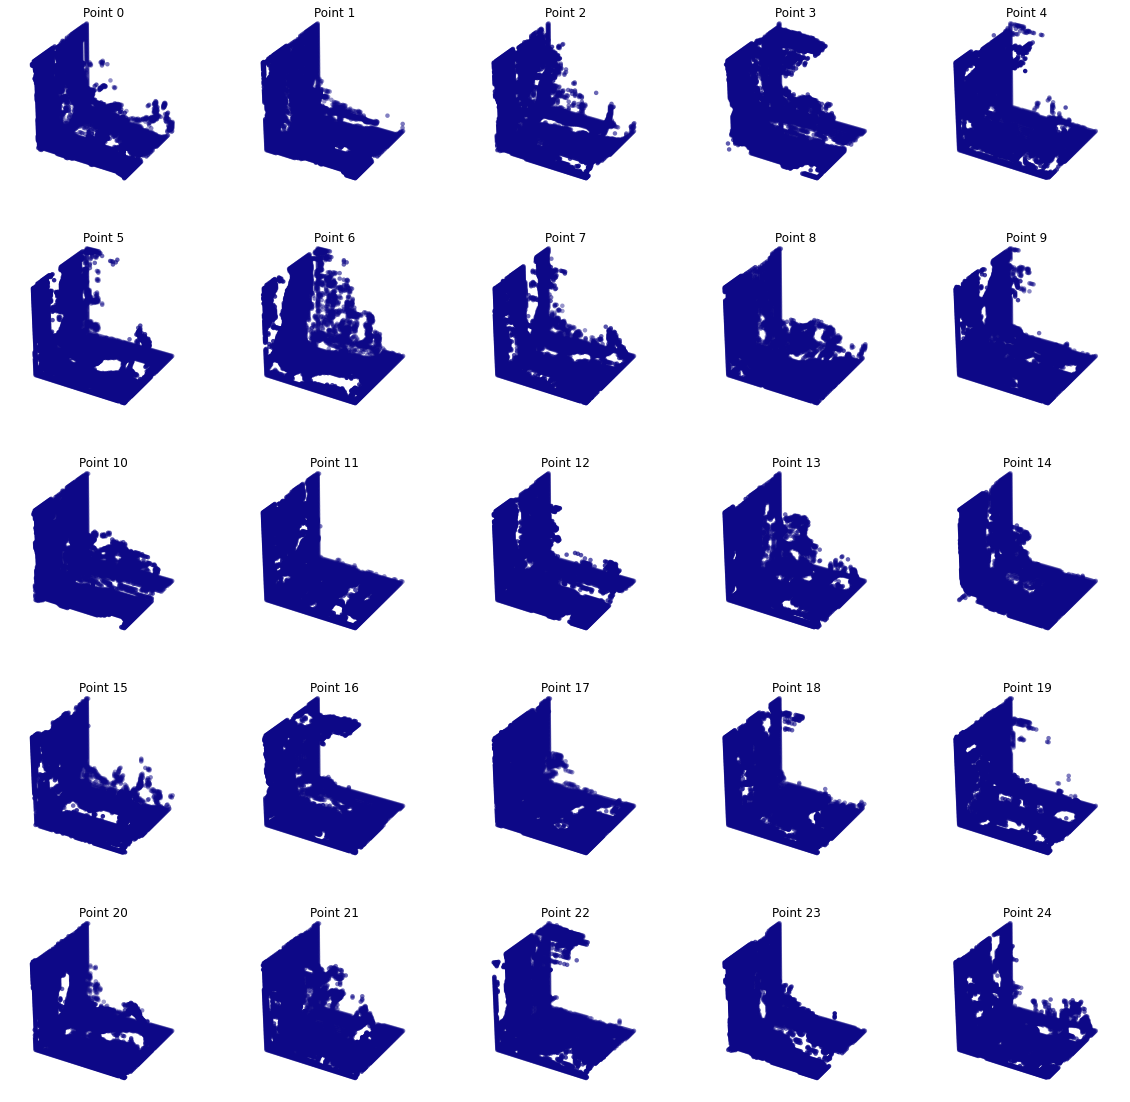

In [ ]:
latent_points = generate_latent_points(100, 25)
# generate images
X  = model.predict(latent_points)


X = np.rint(X)

# plot the result
plot_samples(X, 5)


16


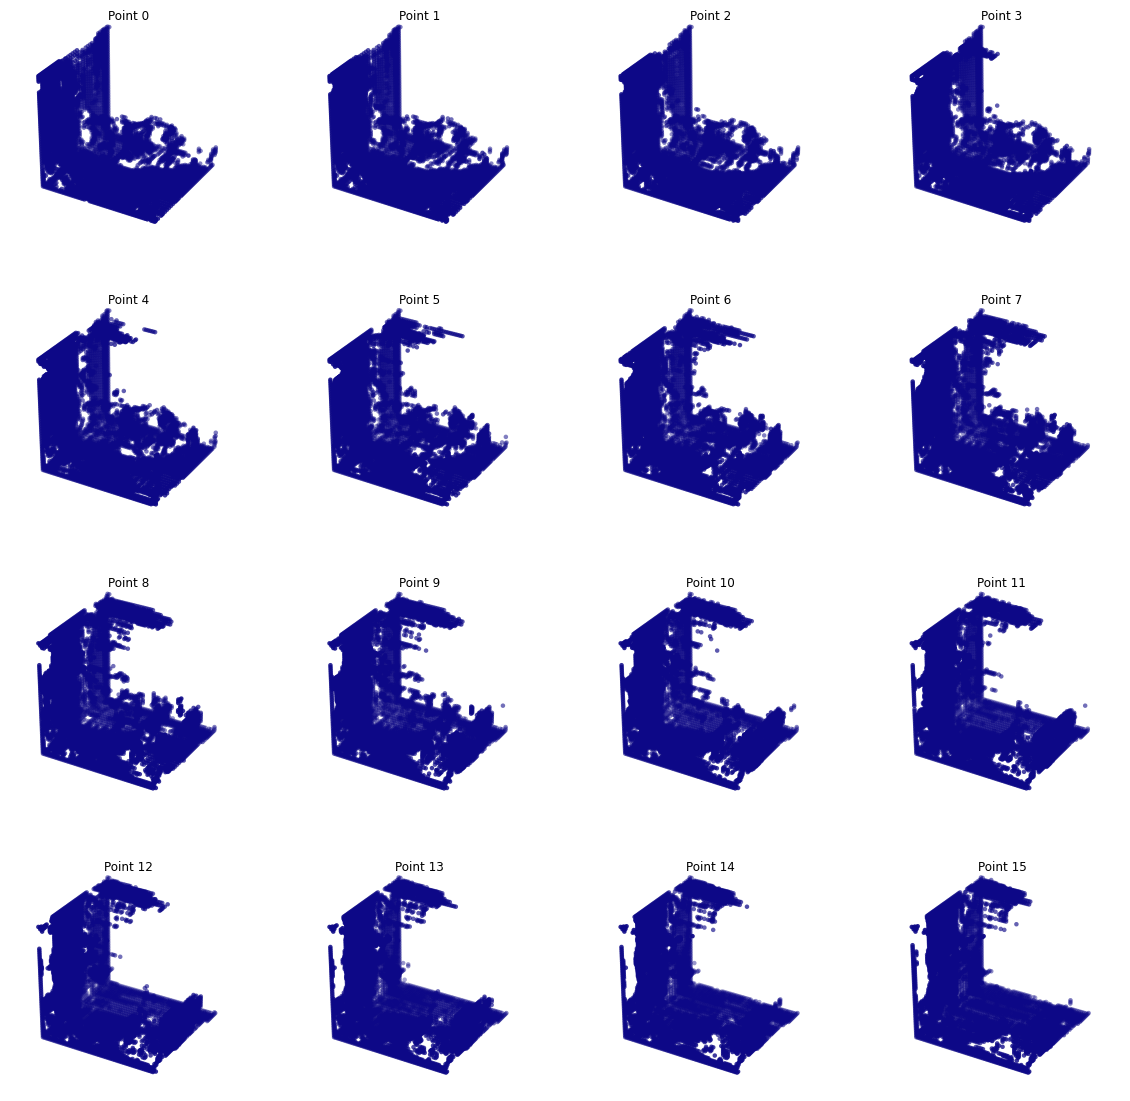

In [ ]:
interpolated = interpolate_points(latent_points[8], latent_points[22], n_steps=16)
print (len(interpolated))

int_X  = model.predict(interpolated)


int_X = np.rint(int_X)

# plot the result
plot_samples(int_X, 4)

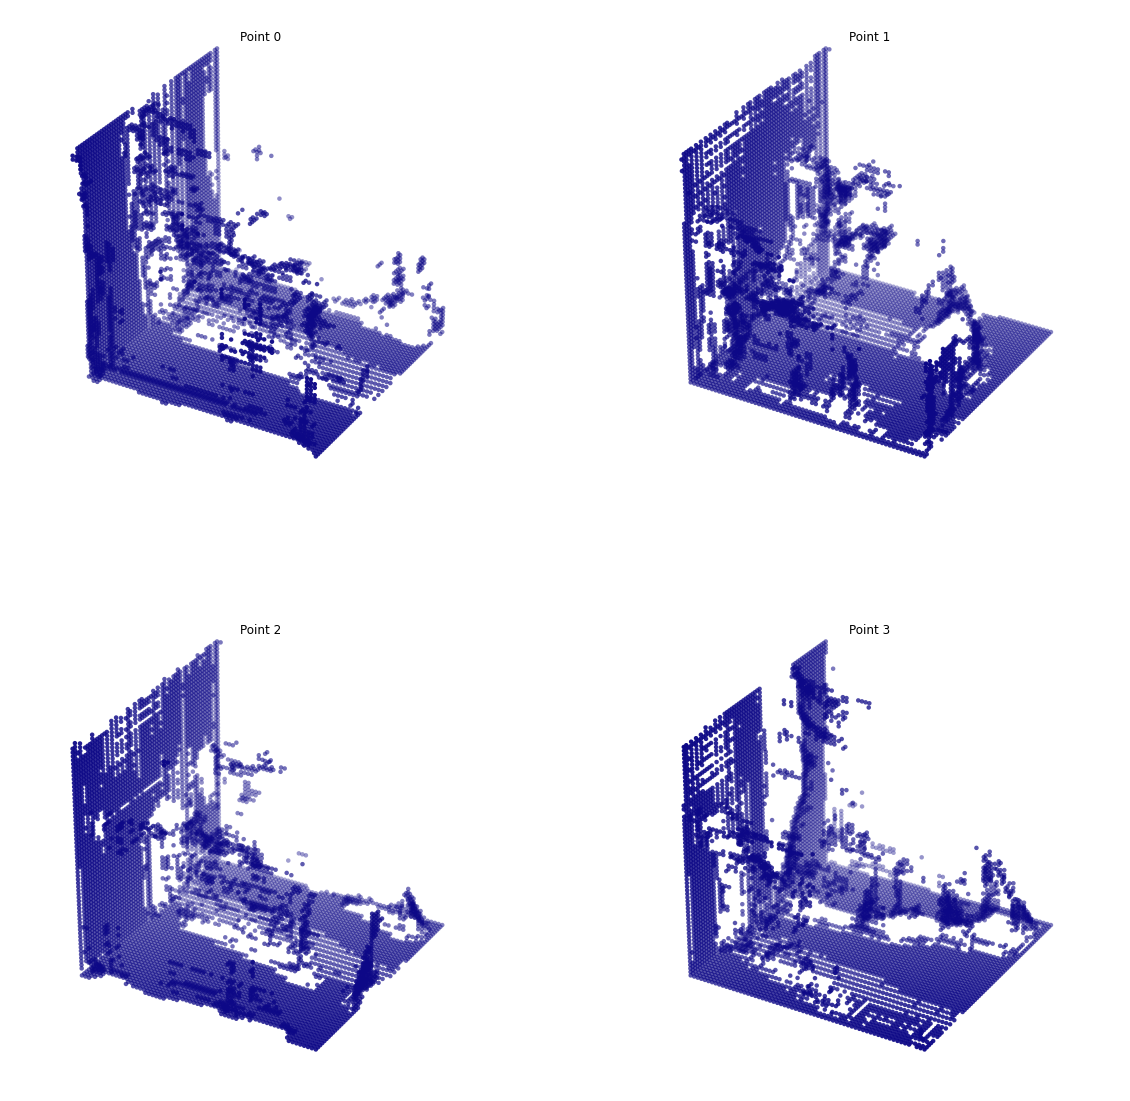

In [ ]:
# average list of latent space vectors
def average_points(points, ix):
	# convert to zero offset points
	zero_ix = [i-1 for i in ix]
	# retrieve required points
	vectors = points[zero_ix]
	# average the vectors
	avg_vector = np.mean(vectors, axis=0)
	# combine original and avg vectors
	all_vectors = np.vstack((vectors, avg_vector))
	return all_vectors
 
# retrieve specific points
walls_ix = [1, 22]
#columns_ix = [2,4]
floor_ix = [8, 13]
# load the saved latent points
points = latent_points
# average vectors
walls = average_points(points, walls_ix)
#columns = average_points(points, columns_ix)
floor = average_points(points, floor_ix)
# combine all vectors

all_vectors = np.vstack((walls, floor))

all_image = model.predict(all_vectors)

all_image = np.rint(all_image)
plot_samples(all_image, 2)


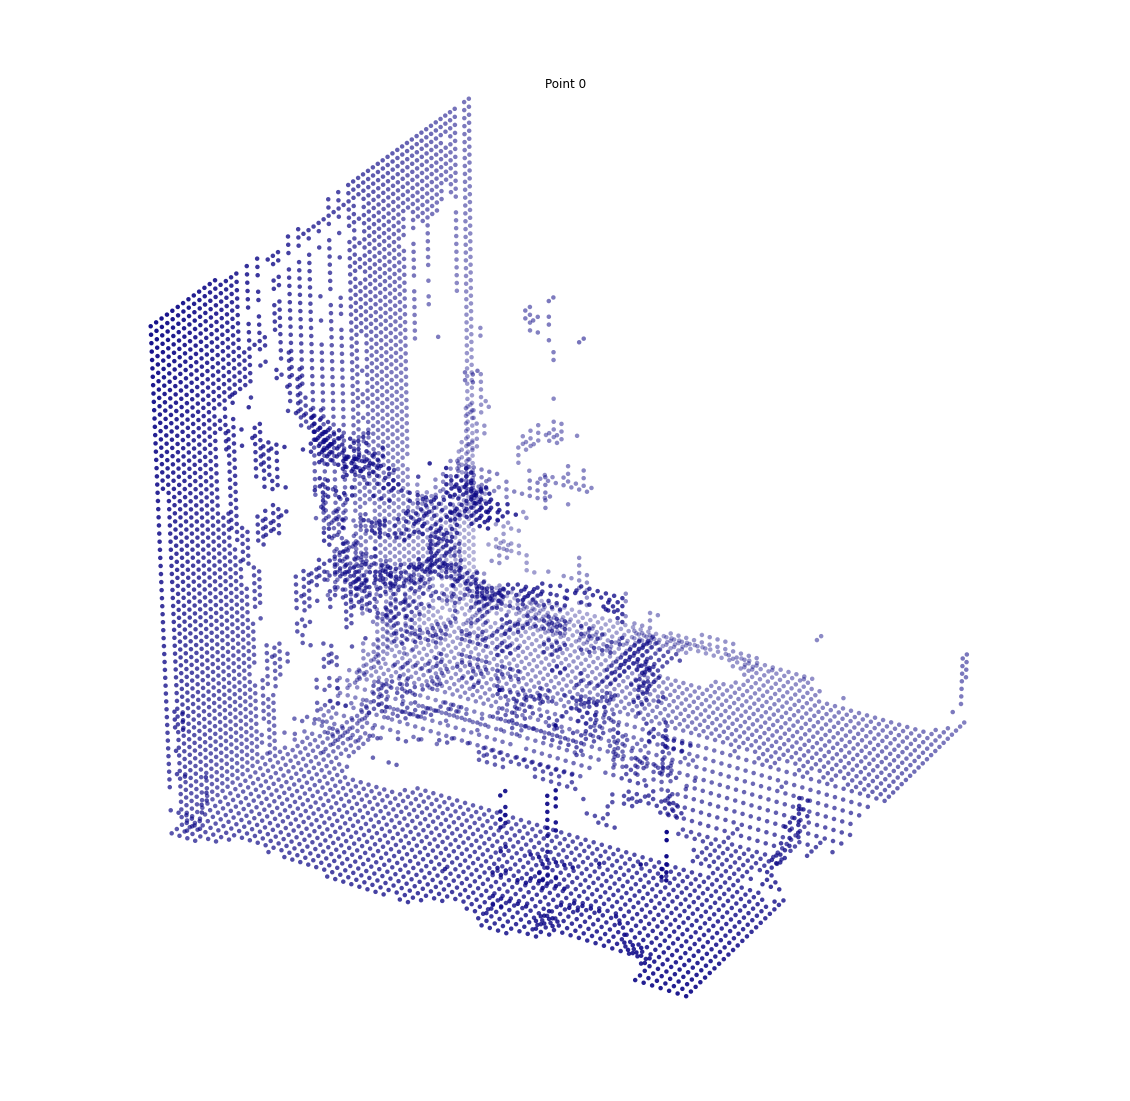

In [ ]:
# walls - floor + column = smiling man
#result_vector = walls[-1] + floor[-1] - columns[-1]
result_vector = walls[-1] + floor[-1] 
# generate image
result_vector = np.expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = np.rint(result_image)
plot_samples(result_image, 1)



In [ ]:
ShowVoxelModel(result_image[:,:,:])

###Reminder, plot real data

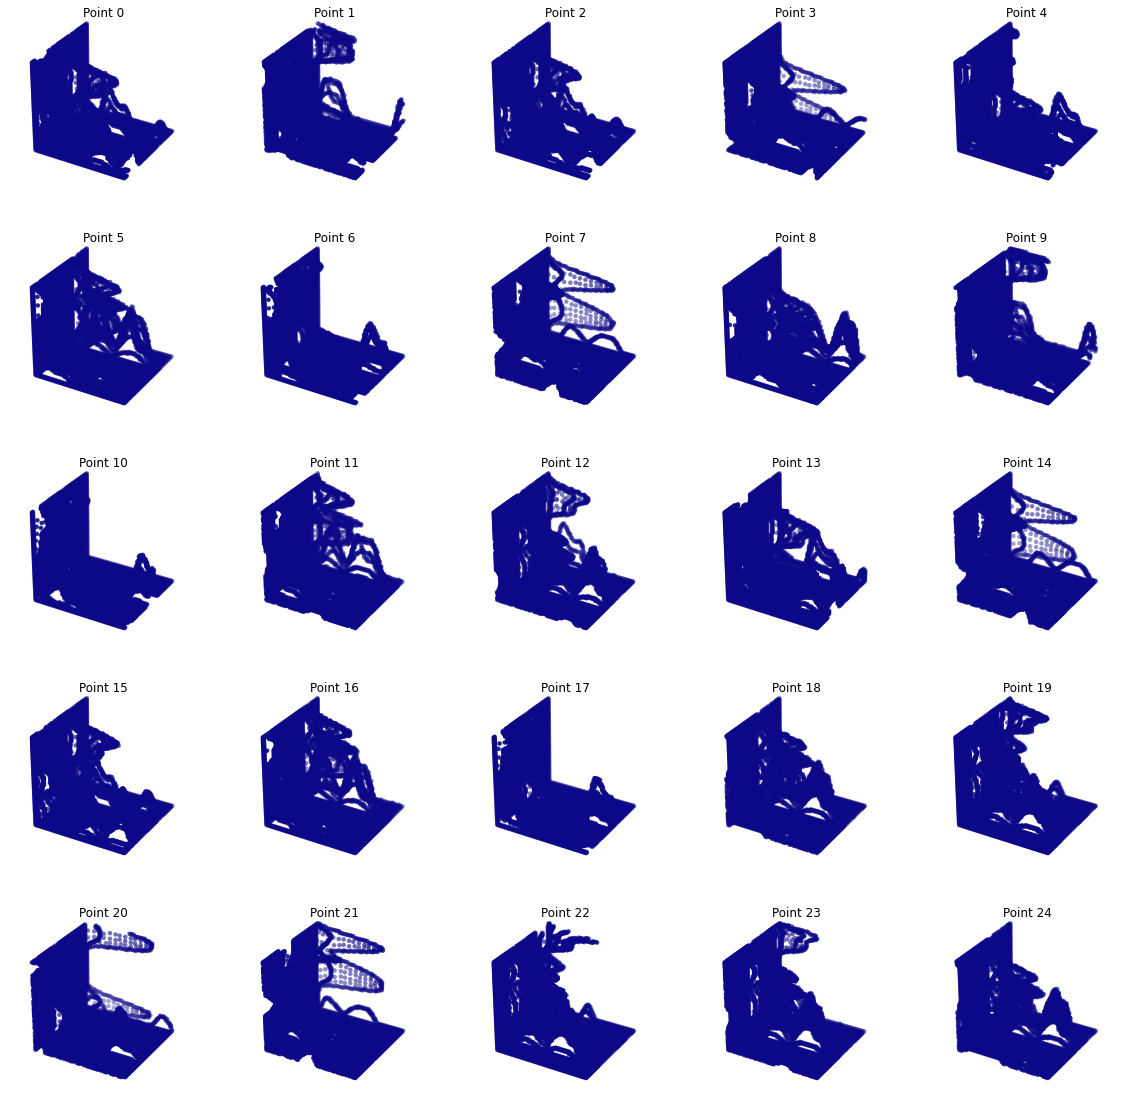

In [ ]:
plot_samples(x_data, 5)